# Advanced Training Techniques

In this lesson, we will cover some more advanced tricks when training neural networks.

## Outline

* Regularization
  * L1 and L2 regularization
  * Dropout 
* Callbacks
* Hyperparameter Tuning
* Classification Models

**Key Vocab**

* Regularization
* Grid Search
* Binary Classification
* Multi-class Classification
* Cross Entropy / Log Loss

In [1]:
import itertools

import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

## What is Regularization?

In the last lesson, we learned that neural networks are very prone to the problem of overfitting due to training data memorization.
Regularization refers to any method you might use to combat overfitting.


## Bigger Networks = More Overfitting

One easy method of regularizing our neural networks is to simply make them smaller, either by reducing the number of hidden layers or making the layers smaller.

In [2]:
# Two neural networks which take one input and one output:

model_small = K.Sequential(name='small_model')

model_small.add(K.layers.Input((1, )))
model_small.add(K.layers.Dense(10, activation='relu'))
model_small.add(K.layers.Dense(1))



model_large = K.Sequential(name='large_model')

model_large.add(K.layers.Input((1, )))
model_large.add(K.layers.Dense(256, activation='relu'))
model_large.add(K.layers.Dense(128, activation='relu'))
model_large.add(K.layers.Dense(64, activation='relu'))
model_large.add(K.layers.Dense(32, activation='relu'))
model_large.add(K.layers.Dense(1))

print(model_small.summary())

print(model_large.summary())

Model: "small_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "large_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,777 (171.00 KB)

 Trainable params: 43,777 (171.00 KB)

 Non-trainable params: 0 (0.00 B)

None


One way we can simplify defining these models is by creating a helper function to build them.

In [3]:
def build_feedforward_network(n_inputs, layer_sizes, name=None):

    model = K.Sequential(name=name)
    
    model.add(K.layers.Input((n_inputs, )))

    for layer_size in layer_sizes:
        model.add(K.layers.Dense(layer_size, activation='relu'))

    model.add(K.layers.Dense(1))

    return model

model_from_func = build_feedforward_network(1, [100, 50, 25, 10], name='from_function')

model_from_func.summary()

Model: "from_function"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 100)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,796 (26.55 KB)

 Trainable params: 6,796 (26.55 KB)

 Non-trainable params: 0 (0.00 B)

Using functions like this, we can quickly test out different model sizes.

## L1 and L2 Regularization: Mathematical Intuition

One common technique involves the inclusion of a _penalty term_ in your loss function.

Recall the loss function definition for a regression problem:

$$J(\vec{w}) = \frac{1}{2N}\sum_{i=1}^N |y_i - f(\vec{x}_i; \vec{w})|^2$$

We can add a penalty term to this loss function which will stop the weights from growing too large.
Two common types of penaly term are L1, and L2. The "L" here stands for [Lesbegue](https://en.wikipedia.org/wiki/Henri_Lebesgue), a late 19th/early 20th century mathematician and _total genius_.

**L1 Regularization:**
$$J(\vec{w}) = \frac{1}{2N}\sum_{i=1}^N |y_i - f(\vec{x}_i; \vec{w})|^2 + \lambda \cdot \sum_{j=1}^K |w_j|$$

**L2 Regularization:**
$$J(\vec{w}) = \frac{1}{2N}\sum_{i=1}^N |y_i - f(\vec{x}_i; \vec{w})|^2 + \lambda \cdot \sum_{j=1}^K w_j^2$$

In these loss functions $\lambda$ is the _regularization strength_.
The larger $\lambda$ is, the more the penalty term dominates the loss function.

> **Question to Ponder:**
>
> Why would making the model weights _smaller_ help combat overfitting?


### What's the Difference Between L1 and L2

From the formulas above, we can see that L1 regularization works by summing the absolute value of the weights, while L2 sums their square.
In each instance, the terms of the sum will all be positive.

It can be somewhat tricky to understand the difference between these two techniques.
Let's fit several models with different regularization strengths to see what happens.

We can use `sklearn` to help with this.

In [4]:
# Use this California house prices dataset

X, y = fetch_california_housing(as_frame=True, return_X_y=True)


# Apply feature scaling
# (Note that you would normally fit this  on the training set and not the test set)
columns = X.columns
X = StandardScaler().fit_transform(X)

X = pd.DataFrame(X, columns=columns)

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818


In [5]:
# When doing linear regression, L1 and L2 have special names called "Lasso" and "Ridge" resp.

saved_weights_l1 = []
saved_weights_l2 = []

# Vary the strength by powers of 2
reg_strengths = [2**r for r in range(-15, 20)]

for reg_strength in reg_strengths:
    # Note: "lambda" is a keyword in Python, so these objects use "alpha" instead.
    l1 = Lasso(alpha=reg_strength)
    l2 = Ridge(alpha=reg_strength)
    
    l1.fit(X, y)
    l2.fit(X, y)
    
    saved_weights_l1.append(l1.coef_)
    saved_weights_l2.append(l2.coef_)

saved_weights_l1 = np.array(saved_weights_l1)
saved_weights_l2 = np.array(saved_weights_l2)

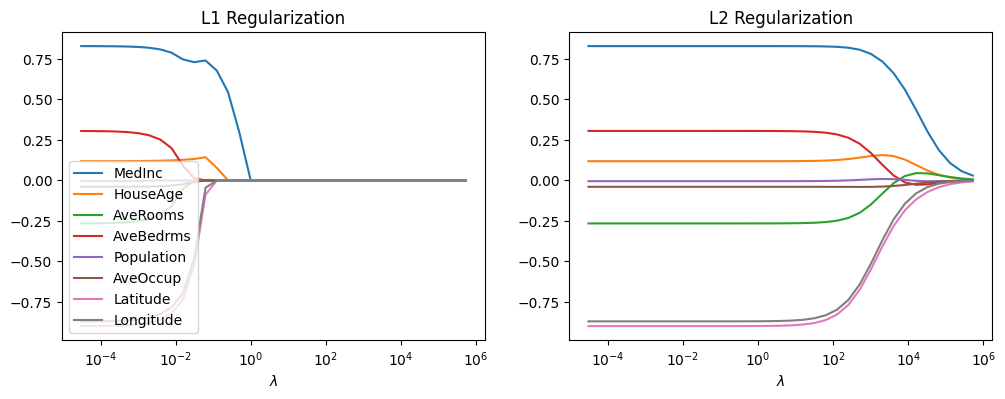

In [6]:
fig, ax = plt.subplots(1, 2)

for weights, name in zip(saved_weights_l1.T, X.columns):
    ax[0].plot(reg_strengths, weights, label=name)

for weights in saved_weights_l2.T:
    ax[1].plot(reg_strengths, weights)

ax[0].set_title('L1 Regularization')
ax[0].set_xlabel('$\lambda$')
ax[0].set_xscale('log')
ax[0].legend()

ax[1].set_title('L2 Regularization')
ax[1].set_xlabel('$\lambda$')
ax[1].set_xscale('log')

fig.set_size_inches(12, 4)

From this picture, we can see the behavior of L1 and L2.
L1 will mostly cause weights to shrink one at a time (sometimes in groups), whereas L2 will cause all the weights to shrink at the same time.

### Regularization in Keras

Keras allows us to impose penalty terms on our layers when we build the network.

In [7]:
def build_regularized_network(n_inputs, layer_sizes, name=None, reg_strength=0.0, reg_type='L1'):
    assert reg_type in ['L1', 'L2'], "Only L1 and L2 regularization supported"

    model = K.Sequential(name=name)
    
    model.add(K.layers.Input((n_inputs, )))

    for layer_size in layer_sizes:
        if reg_type == 'L1':
            regularizer = K.regularizers.L1(reg_strength)
        else:
            regularizer = K.regularizers.L2(reg_strength)
        
        layer = K.layers.Dense(
            layer_size, 
            activation='relu', 
            kernel_regularizer=regularizer,
        )
        model.add(layer)

    model.add(K.layers.Dense(1))

    model.compile(loss='mse')

    return model

model = build_regularized_network(
    n_inputs=X.shape[1], 
    layer_sizes=[16, 16], 
    name='California_Housing',
    reg_strength=10.0,
    reg_type='L2',
)

model.summary()

Model: "California_Housing"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

### Dropout

Another type of regularization uniquely avaliable to neural networks is dropout.
[Dropout Layers](https://keras.io/api/layers/regularization_layers/dropout/) are special layers you add in your neural network.
When the model is fully trained, the layers do absolutely nothing.
However, while the model is training they layers apply the dropout operation.
From the Keras documentation:
> The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1 / (1 - rate) such that the sum over all inputs is unchanged.

In other words, dropout layers will randomly cancel out weights while the model is training.
This ensures that there are not a small collection of weights within the model dominating the behavior of the network.
Instead, the entire network will contribute to learning the desired relationship.

In [8]:
def build_dropout_network(n_inputs, layer_sizes, name=None, dropout_rate = 0.0):
    model = K.Sequential(name=name)
    
    model.add(K.layers.Input((n_inputs, )))

    for layer_size in layer_sizes:
        layer = K.layers.Dense(
            layer_size, 
            activation='relu', 
        )
        model.add(layer)
        model.add(K.layers.Dropout(rate=dropout_rate))

    model.add(K.layers.Dense(1))

    model.compile(loss='mse')

    return model

In deep learning, there are many other options for deal with regularization with lots of room for creative solutions!

## Callbacks in Keras

In programming, a callback refers to a function which is called under certain circumstances.
Keras supports callbacks which can be called while the model is training.
There are builtin callbacks and you can also create your own.

### Early Stopping

One problem you may encounter while training a model is that you start to overfit due to too many training epochs.
We can address this by using an [_early stopping callback_](https://keras.io/api/callbacks/early_stopping/).
While the model is training, at the end of each epoch the validation loss is calculated.
If the loss has gone up instead of down, then the model will stop training early.

In [9]:
# X still contains the California housing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = K.Sequential()
model.add(K.layers.Input((X.shape[1], )))
model.add(K.layers.Dense(64, activation='relu'))
model.add(K.layers.Dense(32, activation='relu'))
model.add(K.layers.Dense(1, activation='linear'))


# Callbacks are defined when you call the fit function
model.compile(loss='mse', optimizer='adam')

# Passing in a patience value lets it go a few epochs w/o improvement.
callback = K.callbacks.EarlyStopping(patience=3)

# Train with a very large number of epochs
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10**4, callbacks=[callback], batch_size=32)

Epoch 1/10000


I0000 00:00:1742337457.355864  104696 service.cc:146] XLA service 0x7f9170006c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742337457.355920  104696 service.cc:154]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
I0000 00:00:1742337457.355927  104696 service.cc:154]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5


137/581 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3946

I0000 00:00:1742337457.850893  104696 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6796 - val_loss: 0.4074
Epoch 2/10000
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3911 - val_loss: 0.3718
Epoch 3/10000
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4024 - val_loss: 0.3619
Epoch 4/10000
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3410 - val_loss: 0.3687
Epoch 5/10000
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3581 - val_loss: 0.3869
Epoch 6/10000
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3260 - val_loss: 0.3331
Epoch 7/10000
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3154 - val_loss: 0.3210
Epoch 8/10000
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3128 - val_loss: 0.3220
Epoch 9/10000
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3011 - val_loss: 0.3358
Epoch 10/10000
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3022 - val_loss: 0.3299


## Different Optimizers and Varying Learning Rates

In the last section, you may have noticed the `optimizer='adam'` in the model compilation.
An optimizer is the component of the algorithm that controls how the gradient descent step is applied.
Two popular optimizers are SGD, and Adam, although there are others.

SDG is the normal stochastic gradient descent.
At each gradient update, a small multiple of the gradient is subtracted from the weights.
This multiple is called the _learning rate_ and is typically referred to by the Greek leter $\eta$ (eta).

Adam, short for _Adaptive Moment Estimation_, applies a variable learning rate that adapts based on what are called first and second moments.
The details are somewhat technical and are outside the scope of this lesson. Suffice it to say, Adam is typically a good first choice for optimizer.

### Specifying The Learning Rate in Keras

We can specify the learning rate when the model is compiled.
Below we train two networks with diffent learning rates, and see how the model's learning curves compare.

In [10]:
histories = []

for learning_rate in [0.001, .002]:
    model = K.Sequential()
    model.add(K.layers.Input((X.shape[1], )))
    model.add(K.layers.Dense(32, activation='relu'))
    model.add(K.layers.Dense(1))

    model.compile(loss='mse', optimizer=K.optimizers.SGD(learning_rate=learning_rate))

    # For this example, fit on the whole dataset
    history = model.fit(X, y, epochs=20)

    histories.append(history)

Epoch 1/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9466
Epoch 2/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6902
Epoch 3/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6127
Epoch 4/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5585
Epoch 5/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5176
Epoch 6/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5057
Epoch 7/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4911
Epoch 8/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4937
Epoch 9/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4850
Epoch 10/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4560
Epoch 11/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4670
Epoch 12/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4544
Epoch 13/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4487
Epoch 14/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4343
Epoch 15/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

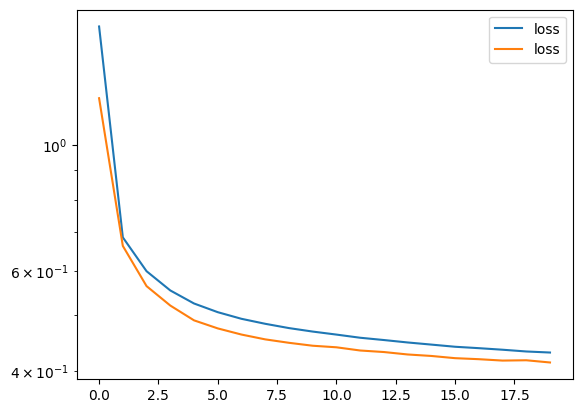

In [11]:
fig, ax = plt.subplots()

pd.DataFrame(histories[0].history).plot(ax=ax)
pd.DataFrame(histories[1].history).plot(ax=ax)

ax.set_yscale('log')

## Hyperparameter Tuning with Grid Search

So far in this lesson, we have covered a lot of examples of various ways you could build your neural networks to solve problems.
A natural question arises: _how do we find the best network?_
This is an example of hyper parameter tuning.

> **Definition**
>
> A **hyperparameter** is a parameter of the training process, as opposed to a parameter (aka weight) of the trained network.

A common method of hyper parameter tuning is the _grid search method_.

1. Define a _grid_ of hyper parameter values you wish to search over.
2. Loop over all cobminations of hyperparameters in your grid.
3. For each HP combination, train a model and evaluate its performance on the validation set.
4. Keep track of the best combination of hyperparameters.

In other words, a grid search is really just a big _guess and check_ operation!

In [12]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Define hyperparameter grid
# Here we will loop over number of layers, layer size, and batch size
param_grid = {
    'num_layers': [2, 3],  # Number of hidden layers
    'units': [32, 64],     # Neurons per layer
    'batch_size': [32, 64],
}

# Generate all combinations of hyperparameters
grid_combinations = list(itertools.product(*param_grid.values()))

best_model = None
best_r2 = 0
best_params = None

# Iterate over each hyperparameter combination
for num_layers, units, batch_size in grid_combinations:
    print(f"Testing config: layers={num_layers}, units={units}, batch_size={batch_size}")

    # Build the model
    model = K.Sequential()
    model.add(K.layers.Input(shape=(X_train.shape[1],)))
    
    for _ in range(num_layers):
        model.add(K.layers.Dense(units, activation='relu'))
    
    model.add(K.layers.Dense(1, activation='linear'))

    # Compile model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[K.metrics.R2Score()],
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=10,  # Keep epochs small for faster tuning
        verbose=0
    )

    # Evaluate performance
    val_r2 = max(history.history['val_r2_score'])
    print(f"Validation R2: {val_r2:.4f}")

    # Store the best model
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_model = model
        best_params = (num_layers, units, batch_size)


print(f"Best Model -> layers={best_params[0]}, units={best_params[1]}, batch_size={best_params[2]}, r2={best_r2:.4f}")

Testing config: layers=2, units=32, batch_size=32
Validation R2: 0.7623
Testing config: layers=2, units=32, batch_size=64
Validation R2: 0.7465
Testing config: layers=2, units=64, batch_size=32
Validation R2: 0.7726
Testing config: layers=2, units=64, batch_size=64
Validation R2: 0.7562
Testing config: layers=3, units=32, batch_size=32
Validation R2: 0.7700
Testing config: layers=3, units=32, batch_size=64
Validation R2: 0.7546
Testing config: layers=3, units=64, batch_size=32
Validation R2: 0.7704
Testing config: layers=3, units=64, batch_size=64
Validation R2: 0.7685
Best Model -> layers=2, units=64, batch_size=32, r2=0.7726


## Classification Models

Up until now, we have focused on models which are intended to output a single value.
However, another common task is _classification_, where you have to determine the class of an input.

With neural networks, it is not very hard to adapt to classification.
You only need to change the model's final output layer, and the loss function!

### Loss Function

Up until now, for regression, we have used Mean Square Error as the loss function.
For classification problems, we instead use _cross entropy_.

### Binary Classification

In binary classification problems, we have exactly two classes of objects.
One class, the _positive class_, is encoded with a 1. The other, the _negative class_, is encoded with a 0.

Just as with logistic regression which we learned about in week 1, we use the `sigmoid` activation layer as our final output layer.
When we compile the model, we use the `binary_crossentropy` loss function.

$$J(\vec{w}) = -\frac{1}{N}\sum_{i=1}^N \left(y_i \cdot \log(p_i) + (1 - y_i)\cdot \log(1 - p_i)\right)$$
Where 
* $y_i$ is either 0 or 1
* $p_i$ is the model's prediction for the probability that sample $i$ is of the positive class ($p_i = f(\vec{x}_i; \vec{w})$)
* $\frac{1}{N}$ is a normalization term.

> **Unpacking the cross entropy formula**
>
> The classification loss function -- with its minus sign, $\log$, and multiple terms -- might at first glance seem somewhat intimidating.
> Let's first take a look at the terms:
> $$y_i \cdot \log(p_i)\,\,\,\,\,\,\,\,\text{and}\,\,\,\,\,\,\,\,(1 - y_i)\cdot \log(1 - p_i)$$
> The value $y_i$ is only zero or one. If it is one, then only the left term contributes. If it is zero, then only the right one does.
> By adding these term together, we make sure that one and only one of them will be non-zero for every sample.
>
> Now, what about the terms themselves? We know that $p_i$ is a (predicted) _probability_ which means it is between 0.0 and 1.0.
> Therefore, $\log(p_i)$ is negative.
>
> ![Log Plot](../images/plot_of_log.png)
>
> Let's imagine that predicted probability is very bad, that is, for a sample where $y_i =1$, the probablity is very small.
> The then log will be a very large negative number!
> Since the cross entropy formula has a minus sign out front, this bad prediction will contribute a lot to the loss.
> A similar argument exists for bad predictions when $y_i = 0$ with the other term.
> This will entice the gradient descent process to focus in on improving the worst predictions the model is making.

Cross entropy is also sometimes called "negative log loss", due to how the formula is defined.

### Multi-class Classification

For multiclass classification, there are more than two potential classes.
Becasue of this we need a different kind of output.
For this we use the _softmax_ activation function, which we covered in Lesson 2:


$$\text{softmax}\left(\vec{x}\right) = \frac{1}{\sum_{j=0}^N e^{x_j}} \cdot \left[\begin{array}{c}
e^{x_0} \\
\vdots \\
e^{x_N}
\end{array} \right]$$

Reminder: This function takes any vector and returns a vector with the properties that
* All entries are between 0.0 and 1.0
* All entries sum up to 1.0

We can thus interpret the entries of this vector as probabilties.

For the loss function, we use `categorical_crossentropy` which is a mutli-class generalization of the binary crossentropy.
Usually, when using Keras, we prefer to use `sparse_categorical_crossentropy`.
This loss function allows us to specify our target vector as a list of integers which represent which class each sample belongs to.

In [13]:
def softmax(x):
    numerator = np.exp(x)
    denominator = numerator.sum()

    return numerator / denominator

sample_input = np.array([1, -2, 2, 0])

logits = softmax(sample_input)

print("Logits: ",logits)
print("Largest probability entry:", np.argmax(logits))

Logits:  [0.24178252 0.01203764 0.65723302 0.08894682]
Largest probability entry: 2


In [14]:
# Define a binary classification model
X, y = make_classification(n_classes=2, n_features=7, n_samples=100)

print("Y vector:")
print(y)

model = K.Sequential()
model.add(K.layers.Dense(32, activation='relu'))
model.add(K.layers.Dense(32, activation='relu'))
model.add(K.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X, y, epochs=10)

# Show what the predicted output looks like:
model.predict(X[:4])

Y vector:
[1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1
 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0
 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.3569 - loss: 0.7644
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5142 - loss: 0.6877 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7139 - loss: 0.6424 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8275 - loss: 0.6127 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9048 - loss: 0.5821 
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9348 - loss: 0.5381 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9109 - loss: 0.5253 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9263 - loss: 0.4970 
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9170 - loss: 0.4771 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0

array([[0.6123627 ],
       [0.7088645 ],
       [0.28668082],
       [0.42035565]], dtype=float32)

In [15]:
# Define a multiclass classification model
X, y = make_classification(n_classes=3, n_features=10, n_samples=100, n_informative=8)

print("Y vector:")
print(y)

model = K.Sequential()
model.add(K.layers.Dense(32, activation='relu'))
model.add(K.layers.Dense(32, activation='relu'))
model.add(K.layers.Dense(3, activation='softmax'))  # Make sure to output a vector with size = the number of classes!

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X, y, epochs=10)

# Show what the predicted output looks like:
model.predict(X[:4])

Y vector:
[0 0 1 1 2 0 0 0 0 0 1 1 2 1 1 0 2 0 0 1 1 0 0 1 2 1 2 1 0 2 0 0 1 1 1 1 0
 2 2 2 0 0 2 1 0 0 2 1 2 2 2 1 1 0 2 2 2 2 2 1 2 1 1 0 1 2 1 1 0 1 0 1 0 2
 0 0 2 2 1 0 2 0 0 1 1 2 2 1 2 2 0 2 0 1 1 2 1 0 0 2]
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.2988 - loss: 1.4573
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3728 - loss: 1.1425 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4085 - loss: 1.0686 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4988 - loss: 0.9972 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5465 - loss: 0.9317 
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4658 - loss: 0.9510 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4977 - loss: 0.8975 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5721 - loss: 0.8406 
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5717 - loss: 0.8339 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0

array([[0.36347878, 0.3933103 , 0.24321091],
       [0.35001743, 0.22281238, 0.42717016],
       [0.24954776, 0.652322  , 0.09813014],
       [0.31813976, 0.53950506, 0.14235511]], dtype=float32)

# Homework

1. Give three examples of regularization techniques you could use when training neural networks and explain how they work.
2. One topic we did not cover in this lesson is the idea of weight constraints. Read the section in the Keras documentaion on [constraints](https://keras.io/api/layers/constraints/). Give an example problem where you think a constraint might make sense and explain your reasoning.
3. Consider this loss function for classification, where we use the raw probabilities _without_ taking the logarithm:

$$J(\vec{w}) = \frac{1}{N}\sum_{i=1}^N \left(y_i \cdot p_i + (1 - y_i)\cdot (1 - p_i)\right)$$

Based on our discussion of the log loss formula, do you think using this changed loss function would improve or harm the model training process? Why?

4. In this lesson, we defined several `build` functions which create neural networks for us. Write your own build function which allows you to create a neural network. Your function should allow you to:
  * Specify the size of the inputs and outputs
  * Specify the number and sizes of each hidden layer
  * Apply regularization
  * Include dropout
  * Include early stopping
  * Specify the loss function
  * Specify any metrics to watch

```python
#Use this function signature

def build_neural_network(
    n_inputs,
    n_outputs,
    layer_sizes,
    dropout_rate=0.0,
    use_early_stopping=False,
    regularization='none',
    regularization_strength=0.0,
    loss_function='mse',
    metrics=None,
):
    ...
    # Fill out the funciton body
```

5. Use the [`sklearn.datasets.fetch_kddcup99`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_kddcup99.html#sklearn.datasets.fetch_kddcup99) to load the KDD Cup 99 dataset.
(This is a classification problem)

Use `sklearn`'s `train_test_split` function to create a test set.
Use your function from (3.) to perform a hyper parameter tuning search to find the best performing hyper parameters on the test set.